<a href="https://colab.research.google.com/github/moni6264/deeplearning2/blob/main/DL_ASS_2_PART(B).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install wandb

     |████████████████████████████████| 1.7 MB 14.4 MB/s 
     |████████████████████████████████| 144 kB 64.3 MB/s 
     |████████████████████████████████| 181 kB 67.0 MB/s 
     |████████████████████████████████| 63 kB 2.1 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=6bd9f0ac77fd9bca669513a4bcf601ffae0fbfb3d5021411e5d3afb1638d5aae
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


In [25]:
import os
import glob
import wandb
import numpy as np 
import random
from wandb.keras import WandbCallback
import tensorflow as tf
from keras.layers import Conv2D , MaxPool2D , Flatten , Dropout, Dense, Activation, BatchNormalization
from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras.models import Sequential, load_model
import random
import wandb
import shutil
from tqdm import tqdm
from keras.callbacks import EarlyStopping, ModelCheckpoint
from wandb.keras import WandbCallback 


%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import shutil
import tensorflow.keras as K
import tensorflow as tf
from tensorflow.keras.optimizers import Adam, SGD, RMSprop



In [4]:
try:
    shutil.rmtree("inaturalist_12K") # helps you automate copying files and directories
except:
    pass

try:
    os.remove("nature_12K.zip")
except:
    pass

In [5]:
%%capture
!unzip "/content/drive/MyDrive/nature_12K.zip"   # location of natural set data

In [6]:
!find . -name "*.DS_Store" -type f -delete #capture the path where your file is currently stored


load a dataset

In [30]:
temp = os.listdir("inaturalist_12K/train")
class_names = [name for name in temp if name != ".DS_Store"] # print class_name (each folder)
print("The names of the classes are:")
print(class_names)

num_classes = len(class_names)
print(f"Number of classes = {num_classes}\n")

M = 0     
M_test = 0

for each_class in class_names:
    train_images = os.listdir("inaturalist_12K/train/"+each_class) # trainset
    test_images = os.listdir("inaturalist_12K/val/"+each_class) # test set
    filtered_train_images = list(filter(lambda x: x!=".DS_Store", train_images)) 
    filtered_test_images = list(filter(lambda x: x!=".DS_Store", test_images))
    M = M + len(filtered_train_images)
    M_test = M_test + len(filtered_test_images)

print(f"Total number of training images = {M}") 
print(f"Total number of test images = {M_test}\n")


The names of the classes are:
['Insecta', 'Amphibia', 'Mammalia', 'Aves', 'Reptilia', 'Arachnida', 'Animalia', 'Plantae', 'Mollusca', 'Fungi']
Number of classes = 10

Total number of training images = 8999
Total number of test images = 2000



spliting validation data

In [31]:
validation_split_fraction = 0.1 # spliting the validation data 

try:
    shutil.rmtree("inaturalist_12K/validation/")  #automate copying files and directories
except:
    pass
    
os.mkdir("inaturalist_12K/validation/") # create the validation path 

for each_class in class_names:
    os.mkdir("inaturalist_12K/validation/"+each_class)
    train_images = os.listdir("inaturalist_12K/train/"+each_class)
    filtered_train_images = list(filter(lambda x: x!=".DS_Store", train_images))
    count = len(filtered_train_images)
    random.shuffle(filtered_train_images) # Shuffle the training images

    validation_images = filtered_train_images[:round(validation_split_fraction*count)]

    for im in validation_images:
        shutil.move("inaturalist_12K/train/"+each_class+"/"+im, "inaturalist_12K/validation/"+each_class+"/"+im) # final create validation imges

Check the input image

In [32]:
input_image_shape = (224, 224, 3)


Spilting data test (train test validation)

In [33]:
def create_generators(train_batch_size, data_aug):

    if data_aug:
        train_data_gen = ImageDataGenerator(rescale=1./255,height_shift_range=0.2, width_shift_range=0.2,
                                        horizontal_flip=True,
                                        zoom_range=0.2,
                                        fill_mode="nearest")
                                       
    else:
        train_data_gen = ImageDataGenerator(rescale=1./255)

    validation_data_gen = ImageDataGenerator(rescale=1./255)

    test_data_gen = ImageDataGenerator(rescale=1./255)

    train_generator = train_data_gen.flow_from_directory(
        'inaturalist_12K/train',
        target_size=input_image_shape[:2],
        color_mode="rgb",
        batch_size=train_batch_size,
        class_mode='categorical',
        shuffle=True,
        seed=42) # random seed is a starting point in generating random numbers

    # batch_size for validation and test generator
    validation_generator = validation_data_gen.flow_from_directory(
        'inaturalist_12K/validation',
        target_size=input_image_shape[:2],
        color_mode="rgb",
        batch_size=100,
        class_mode='categorical',
        shuffle=True,
        seed=42)

    test_generator = test_data_gen.flow_from_directory(
        'inaturalist_12K/val',
        target_size=input_image_shape[:2],
        color_mode="rgb",
        batch_size=100,
        class_mode='categorical',
        shuffle=False,
        seed=42)
    
    return train_generator, validation_generator, test_generator

Build model in image net 

In [34]:
def define_model(pretrained_model_name, activation_function_dense, fc_layer, dropout, pre_layer_train=None):
  # keras sequential model based on a pre-trained model intended to be fine tuned and fc fulled connected 
    

    input_ = K.Input(shape = input_image_shape)

    # add a pretrained model without the top dense layer
    if pretrained_model_name == 'ResNet50':
      pretrained_model = K.applications.ResNet50(include_top = False, weights='imagenet',input_tensor = input_)
    elif pretrained_model_name == 'InceptionV3':
      pretrained_model = K.applications.InceptionV3(include_top = False, weights='imagenet',input_tensor = input_)
    elif pretrained_model_name == 'InceptionResNetV2':
      pretrained_model = K.applications.InceptionResNetV2(include_top = False, weights='imagenet',input_tensor = input_)
    else:
      pretrained_model = K.applications.Xception(include_top = False, weights='imagenet',input_tensor = input_)
    
    #freeze all layers
    for layer in pretrained_model.layers:
        layer.trainable=False 
    
    #set some of the top layers as trainable
    if pre_layer_train:
      for layer in pretrained_model.layers[-pre_layer_train:]:
        layer.trainable=True

    model = K.models.Sequential()
    model.add(pretrained_model)#add pretrained model
    model.add(Flatten()) # The flatten layer is essential to convert the activation  map into a column vector
    model.add(Dense(fc_layer, activation=activation_function_dense))#add a dense layer
    model.add(Dropout(dropout)) # For dropout
    model.add(Dense(10, activation="softmax"))#softmax layer

    return model

Training validation model 

In [36]:
def train_validate_model(train_batch_size, pre_train_model, data_aug, activation_function_dense, fc_layer, dropout, pre_layer_train=None):
# train the model based on the given hyperparameters and plot train validatiob accuracy with each epochs 
  # Create the data generators
  train_generator, validation_generator, test_generator = create_generators(train_batch_size, data_aug)
    
  # Define the model
  model = define_model(pretrained_model_name=pre_train_model, activation_function_dense=activation_function_dense, fc_layer=fc_layer, dropout=dropout, pre_layer_train=pre_layer_train)
  print(model.summary()) # create model 

  TRAIN_STEP_SIZE = train_generator.n//train_generator.batch_size # declare step size for train data
  VALIDATION_STEP_SIZE = validation_generator.n//validation_generator.batch_size # declare step size for validation data

  #compile
  model.compile(optimizer=Adam(lr=0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy']) # compiler with optimizer and loss

  # Early Stopping callback
  earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min') # regularization technique
# save the best model 
  mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)

  history = model.fit(train_generator,
                      steps_per_epoch = TRAIN_STEP_SIZE,
                      validation_data = validation_generator,
                      validation_steps = VALIDATION_STEP_SIZE,
                      epochs=5, 
                      callbacks=[earlyStopping, mc],
                      verbose=2)
    # plot for accuracy vs validation accuracy 

  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()
    # plot for loss vs validation loss 

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()

  return history

Image net with hyper parameter 

In [37]:
pre_train_model = "Xception"#change here to change model for wandb sweeps InceptionV3, InceptionResNetV2, ResNet50, Xception
activation_function_dense = "relu"#set as constant 

create with sweeps and trained model 

In [38]:
def train_validate_model():
    config_defaults = {
        "data_aug": True,
        "train_batch_size": 128,
        "dropout": 0,
        "fc_layer": 256,
        "pre_layer_train": None,
        "epochs": 5
    }

    # Initialize a new wandb ru
    wandb.init(config=config_defaults)
    
    # Config is a variable that have sweeps 
    config = wandb.config

    # Local variables
    data_aug = config.data_aug
    train_batch_size = config.train_batch_size
    dropout = config.dropout
    fc_layer = config.fc_layer
    pre_layer_train = config.pre_layer_train
    epochs = config.epochs
    
    # Display the hyperparameters 
    run_name = "model_{}_aug_{}_bs_{}_drop_{}_fc_{}_fre_{}_epoc_{}".format(pre_train_model, data_aug, train_batch_size, dropout, fc_layer, pre_layer_train, epochs )
    print(run_name)

    # Create the generator 
    train_generator, validation_generator, test_generator = create_generators(train_batch_size, data_aug)
    
    # Define the model
    model = define_model(pretrained_model_name=pre_train_model, activation_function_dense=activation_function_dense, fc_layer=fc_layer, dropout=dropout, pre_layer_train=pre_layer_train)
    print(model.count_params())

    #declare step size both training and validation 

    TRAIN_STEP_SIZE = train_generator.n//train_generator.batch_size
    VALIDATION_STEP_SIZE = validation_generator.n//validation_generator.batch_size

    #compile with optimizer and loss function 

    model.compile(optimizer=Adam(lr=0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

    # Early Stopping callback
    earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')

    # To save the model with best validation accuracy
    mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)

    history = model.fit(train_generator,
                        steps_per_epoch = TRAIN_STEP_SIZE,
                        validation_data = validation_generator,
                        validation_steps = VALIDATION_STEP_SIZE,
                        epochs=epochs, 
                        callbacks=[WandbCallback(data_type="image", generator=validation_generator), earlyStopping, mc],
                        verbose=2)
    # plot for accuracy vs validation accuracy 
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    # plot for loss vs validation loss 
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    
    # Meaningful name for the run
    wandb.run.name = run_name
    wandb.run.save()
    wandb.run.finish()
    return history

Running sweeps configuration 

Create sweep with ID: 4bdmgrzn
Sweep URL: https://wandb.ai/moni6264/test_imagenet_5/sweeps/4bdmgrzn


wandb: Agent Starting Run: mdolctbd with config:
wandb: 	data_aug: True
wandb: 	dropout: 0.2
wandb: 	epochs: 15
wandb: 	fc_layer: 512
wandb: 	pre_layer_train: 10
wandb: 	train_batch_size: 128


model_Xception_aug_True_bs_128_drop_0.2_fc_512_fre_10_epoc_15
Found 8099 images belonging to 10 classes.
Found 900 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
wandb: WARNING The data_type argument of wandb.keras.WandbCallback is deprecated and will be removed in a future release. Please use input_type instead.
wandb: WARNING Setting input_type = data_type.


72247346
Epoch 1/15
63/63 - 225s - loss: 1.3062 - accuracy: 0.5876 - val_loss: 1.0257 - val_accuracy: 0.7189 - _timestamp: 1648021958.0000 - _runtime: 228.0000 - 225s/epoch - 4s/step
Epoch 2/15
63/63 - 202s - loss: 0.8711 - accuracy: 0.7062 - val_loss: 0.9567 - val_accuracy: 0.7322 - _timestamp: 1648022161.0000 - _runtime: 431.0000 - 202s/epoch - 3s/step
Epoch 3/15
63/63 - 191s - loss: 0.7593 - accuracy: 0.7422 - val_loss: 0.9087 - val_accuracy: 0.7322 - _timestamp: 1648022355.0000 - _runtime: 625.0000 - 191s/epoch - 3s/step
Epoch 4/15
63/63 - 186s - loss: 0.6643 - accuracy: 0.7769 - val_loss: 0.8902 - val_accuracy: 0.7511 - _timestamp: 1648022538.0000 - _runtime: 808.0000 - 186s/epoch - 3s/step
Epoch 5/15
63/63 - 179s - loss: 0.5757 - accuracy: 0.8014 - val_loss: 0.9460 - val_accuracy: 0.7422 - _timestamp: 1648022739.0000 - _runtime: 1009.0000 - 179s/epoch - 3s/step
Epoch 6/15
63/63 - 183s - loss: 0.4870 - accuracy: 0.8324 - val_loss: 0.8521 - val_accuracy: 0.7478 - _timestamp: 164802

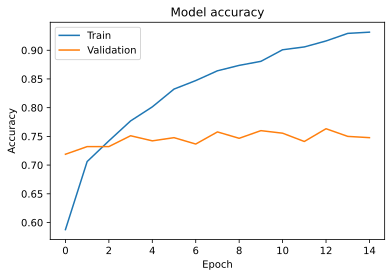

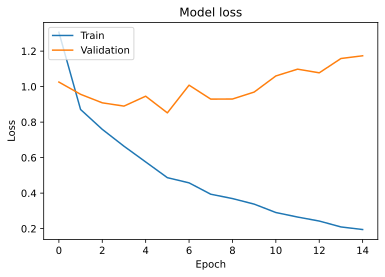

wandb: WARNING Calling wandb.run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


accuracy,▁▃▄▅▅▆▆▇▇▇▇▇███
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▅▅▄▃▃▃▂▂▂▂▁▁▁▁
val_accuracy,▁▃▃▆▅▆▄▇▅▇▇▅█▆▆
val_loss,▅▃▂▂▃▁▄▃▃▄▆▆▆██
accuracy,0.9315
best_epoch,5
best_val_loss,0.8521
epoch,14
loss,0.1949
val_accuracy,0.74778


wandb: Agent Starting Run: 5obr0vr6 with config:
wandb: 	data_aug: False
wandb: 	dropout: 0.1
wandb: 	epochs: 10
wandb: 	fc_layer: 256
wandb: 	pre_layer_train: 10
wandb: 	train_batch_size: 64


model_Xception_aug_False_bs_64_drop_0.1_fc_256_fre_10_epoc_10
Found 8099 images belonging to 10 classes.
Found 900 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
46554418
Epoch 1/10
126/126 - 121s - loss: 1.0232 - accuracy: 0.6703 - val_loss: 0.9611 - val_accuracy: 0.7067 - _timestamp: 1648024861.0000 - _runtime: 128.0000 - 121s/epoch - 963ms/step
Epoch 2/10
126/126 - 113s - loss: 0.4185 - accuracy: 0.8605 - val_loss: 0.9478 - val_accuracy: 0.7533 - _timestamp: 1648024975.0000 - _runtime: 242.0000 - 113s/epoch - 898ms/step
Epoch 3/10
126/126 - 111s - loss: 0.1522 - accuracy: 0.9530 - val_loss: 1.0455 - val_accuracy: 0.7556 - _timestamp: 1648025088.0000 - _runtime: 355.0000 - 111s/epoch - 882ms/step
Epoch 4/10
126/126 - 109s - loss: 0.0595 - accuracy: 0.9866 - val_loss: 1.1099 - val_accuracy: 0.7478 - _timestamp: 1648025199.0000 - _runtime: 466.0000 - 109s/epoch - 866ms/step
Epoch 5/10
126/126 - 119s - loss: 0.0230 - accuracy: 0.9966 - val_loss: 1.0468 - val_

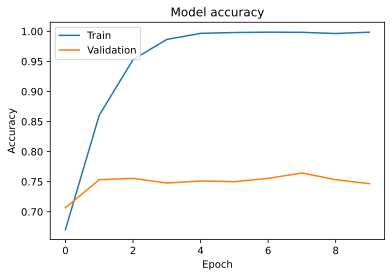

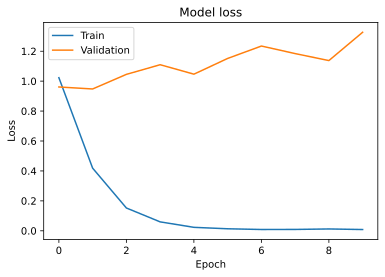

accuracy,▁▅▇███████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▂▁▁▁▁▁▁▁
val_accuracy,▁▇▇▆▆▆▇█▇▆
val_loss,▁▁▃▄▃▅▆▅▅█
accuracy,0.99863
best_epoch,1
best_val_loss,0.94779
epoch,9
loss,0.00831
val_accuracy,0.74667


wandb: Agent Starting Run: io95bnt9 with config:
wandb: 	data_aug: False
wandb: 	dropout: 0.2
wandb: 	epochs: 5
wandb: 	fc_layer: 256
wandb: 	pre_layer_train: None
wandb: 	train_batch_size: 128


model_Xception_aug_False_bs_128_drop_0.2_fc_256_fre_None_epoc_5
Found 8099 images belonging to 10 classes.
Found 900 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
46554418
Epoch 1/5
63/63 - 116s - loss: 1.0821 - accuracy: 0.6620 - val_loss: 0.7721 - val_accuracy: 0.7578 - _timestamp: 1648026105.0000 - _runtime: 123.0000 - 116s/epoch - 2s/step
Epoch 2/5
63/63 - 109s - loss: 0.6373 - accuracy: 0.7872 - val_loss: 0.7575 - val_accuracy: 0.7522 - _timestamp: 1648026216.0000 - _runtime: 234.0000 - 109s/epoch - 2s/step
Epoch 3/5
63/63 - 108s - loss: 0.4394 - accuracy: 0.8485 - val_loss: 0.7810 - val_accuracy: 0.7333 - _timestamp: 1648026358.0000 - _runtime: 376.0000 - 108s/epoch - 2s/step
Epoch 4/5
63/63 - 108s - loss: 0.3024 - accuracy: 0.9011 - val_loss: 0.8191 - val_accuracy: 0.7556 - _timestamp: 1648026501.0000 - _runtime: 519.0000 - 108s/epoch - 2s/step
Epoch 5/5
63/63 - 108s - loss: 0.2101 - accuracy: 0.9418 - val_loss: 0.8542 - val_accuracy: 0.7511 - _times

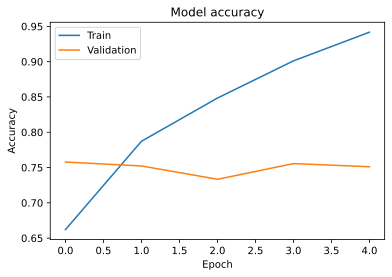

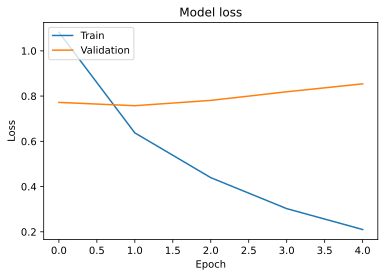

accuracy,▁▄▆▇█
epoch,▁▃▅▆█
loss,█▄▃▂▁
val_accuracy,█▆▁▇▆
val_loss,▂▁▃▅█
accuracy,0.94179
best_epoch,1
best_val_loss,0.75747
epoch,4
loss,0.21008
val_accuracy,0.75111


wandb: Agent Starting Run: wopnumki with config:
wandb: 	data_aug: False
wandb: 	dropout: 0.1
wandb: 	epochs: 10
wandb: 	fc_layer: 128
wandb: 	pre_layer_train: 20
wandb: 	train_batch_size: 128


model_Xception_aug_False_bs_128_drop_0.1_fc_128_fre_20_epoc_10
Found 8099 images belonging to 10 classes.
Found 900 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
33707954
Epoch 1/10
63/63 - 118s - loss: 1.0438 - accuracy: 0.6593 - val_loss: 0.9503 - val_accuracy: 0.7333 - _timestamp: 1648026824.0000 - _runtime: 126.0000 - 118s/epoch - 2s/step
Epoch 2/10
63/63 - 113s - loss: 0.4366 - accuracy: 0.8552 - val_loss: 0.9305 - val_accuracy: 0.7678 - _timestamp: 1648026937.0000 - _runtime: 239.0000 - 113s/epoch - 2s/step
Epoch 3/10
63/63 - 111s - loss: 0.1715 - accuracy: 0.9502 - val_loss: 1.2654 - val_accuracy: 0.7478 - _timestamp: 1648027051.0000 - _runtime: 353.0000 - 111s/epoch - 2s/step
Epoch 4/10
63/63 - 110s - loss: 0.0666 - accuracy: 0.9851 - val_loss: 1.2212 - val_accuracy: 0.7578 - _timestamp: 1648027162.0000 - _runtime: 464.0000 - 110s/epoch - 2s/step
Epoch 5/10
63/63 - 111s - loss: 0.0270 - accuracy: 0.9962 - val_loss: 1.2004 - val_accuracy: 0.7656 - _t

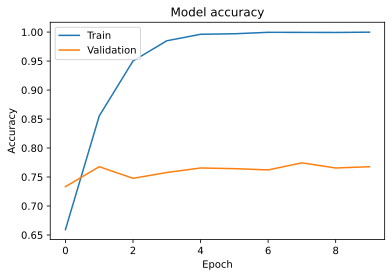

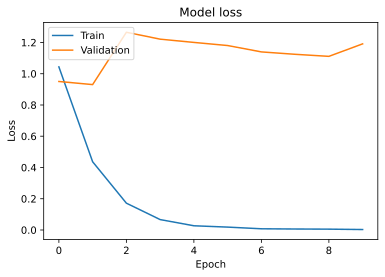

accuracy,▁▅▇███████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▂▁▁▁▁▁▁▁
val_accuracy,▁▇▃▅▆▆▆█▆▇
val_loss,▁▁█▇▇▆▅▅▅▆
accuracy,0.99987
best_epoch,1
best_val_loss,0.93046
epoch,9
loss,0.0029
val_accuracy,0.76778


wandb: Agent Starting Run: jk3vwm1u with config:
wandb: 	data_aug: False
wandb: 	dropout: 0.1
wandb: 	epochs: 10
wandb: 	fc_layer: 128
wandb: 	pre_layer_train: 10
wandb: 	train_batch_size: 64


model_Xception_aug_False_bs_64_drop_0.1_fc_128_fre_10_epoc_10
Found 8099 images belonging to 10 classes.
Found 900 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
33707954
Epoch 1/10
126/126 - 116s - loss: 1.0257 - accuracy: 0.6712 - val_loss: 1.0646 - val_accuracy: 0.6989 - _timestamp: 1648028096.0000 - _runtime: 123.0000 - 116s/epoch - 922ms/step
Epoch 2/10
126/126 - 111s - loss: 0.4444 - accuracy: 0.8483 - val_loss: 1.0832 - val_accuracy: 0.7344 - _timestamp: 1648028210.0000 - _runtime: 237.0000 - 111s/epoch - 880ms/step
Epoch 3/10
126/126 - 111s - loss: 0.1846 - accuracy: 0.9440 - val_loss: 0.9120 - val_accuracy: 0.7456 - _timestamp: 1648028319.0000 - _runtime: 346.0000 - 111s/epoch - 880ms/step
Epoch 4/10
126/126 - 110s - loss: 0.0701 - accuracy: 0.9829 - val_loss: 0.9395 - val_accuracy: 0.7589 - _timestamp: 1648028462.0000 - _runtime: 489.0000 - 110s/epoch - 876ms/step
Epoch 5/10
126/126 - 109s - loss: 0.0294 - accuracy: 0.9951 - val_loss: 1.0322 - val_

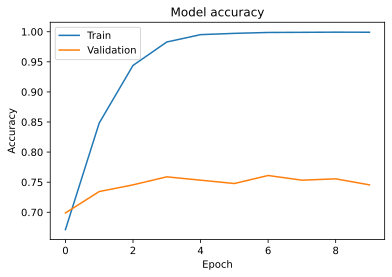

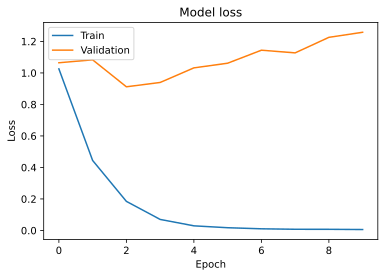

accuracy,▁▅▇███████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▂▁▁▁▁▁▁▁
val_accuracy,▁▅▆█▇▆█▇▇▆
val_loss,▄▄▁▂▃▄▆▅▇█
accuracy,0.99913
best_epoch,2
best_val_loss,0.91199
epoch,9
loss,0.00591
val_accuracy,0.74556


In [39]:
sweep_config = {
  "name": "Test part B ",
  "metric": {
      "name":"val_accuracy",
      "goal": "maximize"
  },
  "method": "random",
  "parameters": {
        "data_aug": {
            "values": [True, False]
        },
        "train_batch_size": {
            "values": [64, 128]
        },
        "dropout": {
            "values": [0, 0.2, 0.1]
        },
        "fc_layer": {
            "values": [128, 256, 512]
        },
        "pre_layer_train": {
            "values": [None, 10, 20]
        },
        "epochs":{
            "values": [5,10,15]
        }
    }
}

sweep_id = wandb.sweep(sweep_config, entity="moni6264", project="test_imagenet_5")
wandb.agent(sweep_id, train_validate_model, count=5)